torch.Size([1801, 16, 16])


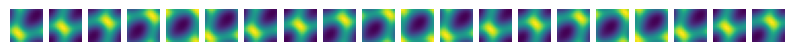

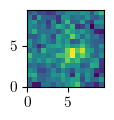

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 11
})

# SETTING = "low_data"
SETTING = "high_data"
assert SETTING in ["low_data", "high_data"]

d = torch.tensor( np.load("ks2d_long.npy") )
print(d.shape)

d_test = d[1600:-1,:,:]
if SETTING == "high_data": d_train = d[900:1200,:,:]
else: d_train = d[900:920,:,:]

L = 3 * np.pi
dt = 1
N_train = d_train.shape[0]
N_test = d_test.shape[0]
n = d.shape[1]
vmin = d.min()
vmax = d.max()

N_plots = 20
fig, ax = plt.subplots(1,N_plots,figsize=(10,2))
for j in range(N_plots):
    ax[j].imshow(d_train[int(N_train*(j/N_plots)),:,:].numpy())
    ax[j].set_axis_off()

plt.show()

fig, ax = plt.subplots(1, 1, figsize=(1,1))
d0 = torch.tensor( np.load("ks2d_initial.npy") )
d0 = d0[::d0.shape[0]//d.shape[1], ::d0.shape[1]//d.shape[2]]
ax.imshow(d0, extent=[0,L,0,L])

fig.savefig(f"plots/initial_data.pdf", bbox_inches='tight')
plt.show()

n_centers = 10
len G = 64
kernel shape = torch.Size([10, 10, 64])


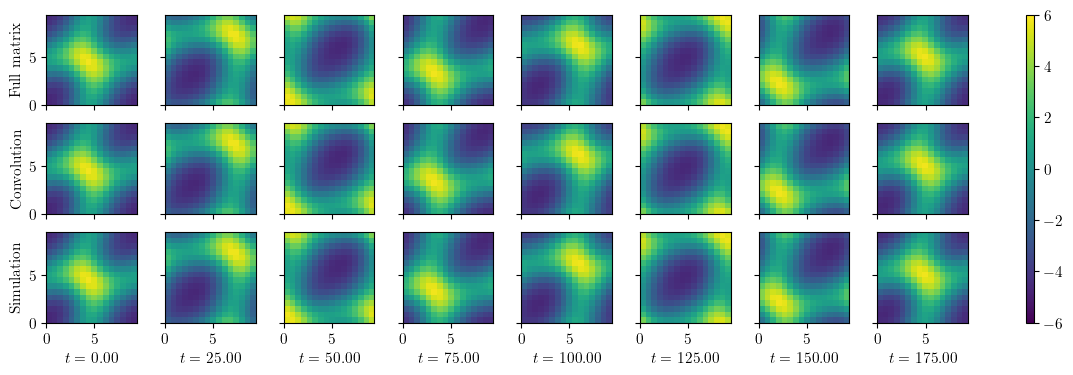

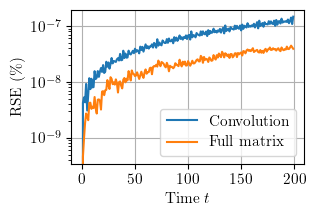

In [20]:
n_centers = 10
I = np.floor(np.linspace(0, 1, n_centers, endpoint=False)*d_train.shape[0]).astype(int)
centers = d_train[I,:,:]

G0, G1 = 8, 8
G = [ (i,j) for i in range(G0) for j in range(G1) ]

def chi(x):
    return torch.exp(-0.5*(x.unsqueeze(1) - centers.unsqueeze(0)).pow(2)).sum(dim=[2,3])

def psi(x, g=None):
    if g is not None: 
        x = torch.roll(x, g[0]*round(n/G0), -2)
        x = torch.roll(x, g[1]*round(n/G1), -1)
        return chi(x)
    else: 
        return torch.stack([psi(x,g) for g in G], dim=2).view(-1, n_centers * len(G))

def fourier(x):
    assert x.shape[-1] == len(G)
    b = x.shape[:-1]
    x = x.view(*b, G0, G1)
    x_hat = torch.fft.fft2(x)
    x_hat = x_hat.view(*b, len(G))
    return x_hat

def inv_fourier(x_hat):
    assert x_hat.shape[-1] == len(G)
    b = x_hat.shape[:-1]
    x_hat = x_hat.view(*b, G0, G1)
    x = torch.fft.ifft2(x_hat).real
    x = x.view(*b, len(G))
    return x

def solve(X_in, X_out):
    X = psi(X_in)
    Y = psi(X_out)
    A = torch.linalg.solve(X.conj().T @ X + 1e-4*torch.eye(X.shape[1]), X.conj().T @ Y).T
    return A

def solve_fourier(X_in, X_out):
    b = X_in.shape[0]
    psi_X_hat = fourier( psi(X_in).view(b, n_centers, len(G)) )
    psi_Y_hat = fourier( psi(X_out).view(b, n_centers, len(G)) )
    A_hat = torch.zeros( (n_centers, n_centers, len(G) ), dtype=torch.complex128 )
    for rho_g in range(len(G)):
        X = psi_X_hat[:,:,rho_g]
        Y = psi_Y_hat[:,:,rho_g]
        A_hat[:,:,rho_g] = torch.linalg.solve(X.conj().T @ X + 1e-4*torch.eye(n_centers), X.conj().T @ Y).T
    A = inv_fourier(A_hat)
    return A, A_hat

def solve_reconstruct(X_in):
    A = torch.linalg.lstsq(psi(X_in), X_in.view(-1, n**2), rcond=1e-9, driver="gelsd").solution.transpose(0,1)
    return A

def group_convolve(A, x):
    b = x.shape[0]
    x = x.view(b, n_centers, len(G))
    A = A.view(n_centers, n_centers, len(G))
    A_hat, x_hat = fourier(A), fourier(x)
    y_hat = torch.einsum("ijk,bjk -> bik", A_hat, x_hat)
    y = inv_fourier(y_hat)
    y = y.view(b, n_centers * len(G))
    return y


K = solve(d_train[:-1,...],d_train[1:,...])
B = solve_reconstruct(d)

print("n_centers =", n_centers)
print("len G =", len(G))

A, A_hat = solve_fourier(d_train[:-1,...],d_train[1:,...])
print("kernel shape =", A.shape)

N_plots = 8
fig, ax = plt.subplots(3, N_plots, figsize=(15, 4), sharex=True, sharey=True)
extent=[0,L,0,L]
vmin, vmax = -6, 6

xs_full = [  ]
xs_conv = [  ]
psis_d_test = psi(d_test)
psis_x_full = [ psis_d_test[0,...] ]
psis_x_conv = [ psis_d_test[0,...] ]

time = torch.arange(d_test.shape[0])*dt

for j in range(N_plots):
    steps = int( N_test / N_plots )
    for k in range(steps):
        xs_full.append( (B @ psis_x_full[-1]).view(n,n) )
        xs_conv.append( (B @ psis_x_conv[-1]).view(n,n) )
        psis_x_full += [ K @ psis_x_full[-1] ]
        psis_x_conv += [ group_convolve(A, psis_x_conv[-1][None,...])[0,...] ]

    im0 = ax[0,j].imshow(xs_full[-steps].numpy(),extent=extent,vmin=vmin,vmax=vmax)
    im1 = ax[1,j].imshow(xs_conv[-steps].numpy(),extent=extent,vmin=vmin,vmax=vmax)
    im2 = ax[2,j].imshow(d_test[int(j*(N_test/N_plots)),:,:].numpy(),extent=extent,vmin=vmin,vmax=vmax)
    ax[2,j].set_xlabel(f"$t = {time[j*steps]:.2f}$")

psis_x_full = psis_x_full[:-1]
psis_x_conv = psis_x_conv[:-1]

ax[0,0].set_ylabel("Full matrix")
ax[1,0].set_ylabel("Convolution")
ax[2,0].set_ylabel("Simulation")
plt.colorbar(im0, ax=ax, aspect=40)

fig.savefig(f"plots/trajectories_{SETTING}.pdf", bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(3,2))
psis_x_full = torch.stack(psis_x_full, dim=0)
psis_x_conv = torch.stack(psis_x_conv, dim=0)
err_full = (psis_x_full - psis_d_test).pow(2).mean(dim=1)
err_conv = (psis_x_conv - psis_d_test).pow(2).mean(dim=1)
divisor = psis_d_test.var(dim=1)
err_full_rel = 100 * err_full / divisor
err_conv_rel = 100 * err_conv / divisor
ax.plot(time, err_conv_rel, label="Convolution")
ax.plot(time, err_full_rel, label="Full matrix")
ax.grid()
ax.legend()
ax.set_ylabel("RSE (\%)")
ax.set_xlabel("Time $t$")

ax.set_yscale("log")

fig.savefig(f"plots/rmse_{SETTING}.pdf", bbox_inches='tight')
plt.show()

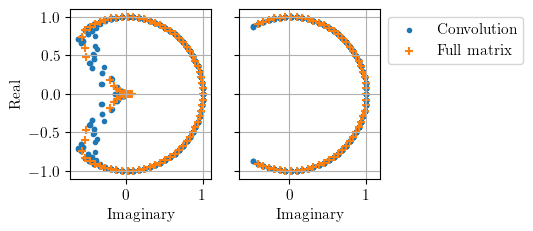

In [21]:
eigvals_K = torch.linalg.eigvals(K)
eigvals_A = torch.linalg.eigvals( A_hat.permute(2, 0, 1) )
eigvals_A = eigvals_A.flatten()

# filter largest eigenvalues
eigvals_A_largest = eigvals_A[ eigvals_A.abs() > 0.995 ]
eigvals_K_largest = eigvals_K[ eigvals_K.abs() > 0.995 ]

fig, ax = plt.subplots(1, 2, figsize=(4,2.2), width_ratios=[0.5,0.5], sharey=True)
ax[0].grid()
ax[1].grid()
ax[0].scatter(eigvals_A.real, eigvals_A.imag, marker=".", label="Convolution")
ax[0].scatter(eigvals_K.real, eigvals_K.imag, marker="+", label="Full matrix")
ax[1].scatter(eigvals_A_largest.real, eigvals_A_largest.imag, marker=".", label="Convolution")
ax[1].scatter(eigvals_K_largest.real, eigvals_K_largest.imag, marker="+", label="Full matrix")
ax[0].axis("equal")
ax[1].axis("equal")
ax[0].set_ylim([-1.1, 1.1])
ax[1].set_ylim([-1.1, 1.1])
ax[1].legend(ncol=1, loc="upper left", bbox_to_anchor=(1.0, 1.0))
ax[1].set_xlabel("Imaginary")
ax[0].set_xlabel("Imaginary")
ax[0].set_ylabel("Real")

fig.savefig(f"plots/evs_{SETTING}.pdf", bbox_inches='tight')
plt.show()